# **Movie Genre Classification**

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.tokenize import TreebankWordTokenizer
import re
import string
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report,accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from scipy.sparse import csr_matrix
from sklearn.model_selection import GridSearchCV

In [6]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Load and Preprocessing the Data

In [7]:
train_data=pd.read_csv(r"D:\mydailywork\Genre Classification Dataset\train_data.txt",sep=':::',names=['ID','TITLE','GENRE','DESCRIPTION'],engine='python')
test_data=pd.read_csv(r"D:\mydailywork\Genre Classification Dataset\test_data_solution.txt",sep=':::',names=['ID','TITLE','GENRE','DESCRIPTION'],engine='python')

In [8]:
train_data.head()

,ID,TITLE,GENRE,DESCRIPTION
0,1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...
1,2,Cupid (1997),thriller,A brother and sister with a past incestuous r...
2,3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...
3,4,The Secret Sin (1915),drama,To help their unemployed father make ends mee...
4,5,The Unrecovered (2007),drama,The film's title refers not only to the un-re...


In [9]:
train_data.shape

(54214, 4)

In [10]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54214 entries, 0 to 54213
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ID           54214 non-null  int64 
 1   TITLE        54214 non-null  object
 2   GENRE        54214 non-null  object
 3   DESCRIPTION  54214 non-null  object
dtypes: int64(1), object(3)
memory usage: 1.7+ MB


In [11]:
train_data.isnull().sum()

ID             0
TITLE          0
GENRE          0
DESCRIPTION    0
dtype: int64

In [12]:
test_data.head()

,ID,TITLE,GENRE,DESCRIPTION
0,1,Edgar's Lunch (1998),thriller,"L.R. Brane loves his life - his car, his apar..."
1,2,La guerra de papá (1977),comedy,"Spain, March 1964: Quico is a very naughty ch..."
2,3,Off the Beaten Track (2010),documentary,One year in the life of Albin and his family ...
3,4,Meu Amigo Hindu (2015),drama,"His father has died, he hasn't spoken with hi..."
4,5,Er nu zhai (1955),drama,Before he was known internationally as a mart...


In [13]:
test_data.shape

(54200, 4)

In [14]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54200 entries, 0 to 54199
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ID           54200 non-null  int64 
 1   TITLE        54200 non-null  object
 2   GENRE        54200 non-null  object
 3   DESCRIPTION  54200 non-null  object
dtypes: int64(1), object(3)
memory usage: 1.7+ MB


In [15]:
test_data.isnull().sum()

ID             0
TITLE          0
GENRE          0
DESCRIPTION    0
dtype: int64

## EDA and Data Visualization

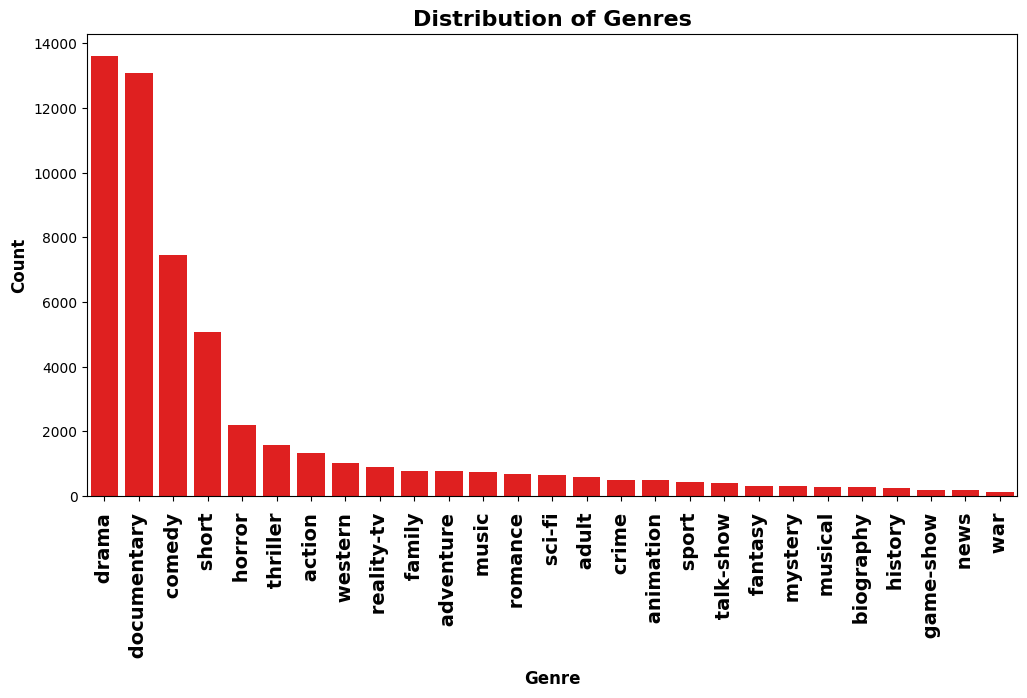

In [16]:
plt.figure(figsize=(12,6))
count=train_data.GENRE.value_counts()
sns.barplot(x = count.index, y = count, color = 'red')
plt.title('Distribution of Genres', fontsize = 16, fontweight = 'bold')
plt.xlabel('Genre', fontsize = 12, fontweight = 'bold')
plt.ylabel('Count', fontsize = 12, fontweight = 'bold')
plt.xticks(rotation = 90, fontsize = 14, fontweight = 'bold');

In [17]:
train_data['LEN'] = train_data['DESCRIPTION'].apply(len)
train_data.head()

,ID,TITLE,GENRE,DESCRIPTION,LEN
0,1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...,546
1,2,Cupid (1997),thriller,A brother and sister with a past incestuous r...,184
2,3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...,650
3,4,The Secret Sin (1915),drama,To help their unemployed father make ends mee...,1082
4,5,The Unrecovered (2007),drama,The film's title refers not only to the un-re...,625


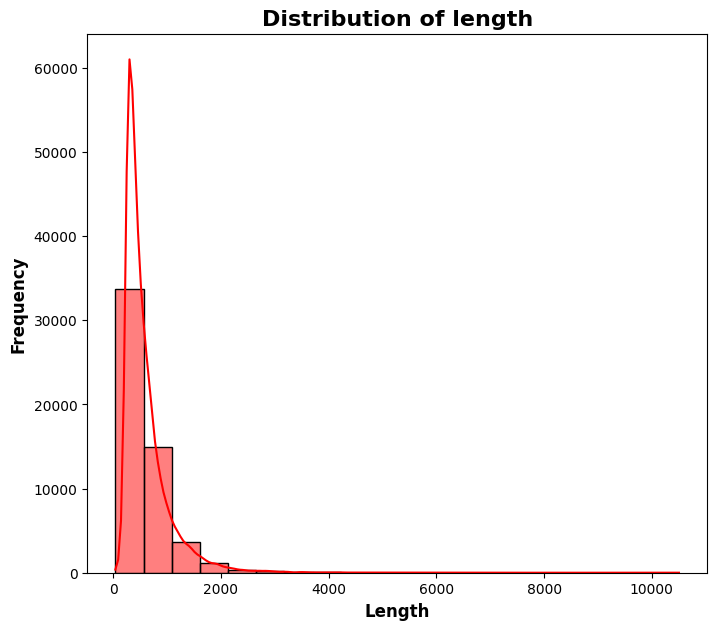

In [18]:
plt.figure(figsize = (8,7))
sns.histplot(data = train_data, x = 'LEN', bins = 20, kde = True, color = 'red')
plt.xlabel('Length', fontsize = 12, fontweight = 'bold')
plt.ylabel('Frequency', fontsize = 12, fontweight = 'bold')
plt.title('Distribution of length', fontsize = 16, fontweight = 'bold')
plt.show()

In [19]:
stemmer = LancasterStemmer()
stop_words = set(stopwords.words('english'))
tokenizer = TreebankWordTokenizer()

def clean_text(text):
    text = text.lower()  # Lowercase all characters
    text = re.sub(r'@\S+', '', text)  # Remove Twitter handles
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'pic.\S+', '', text)
    text = re.sub(r"[^a-zA-Z+']", ' ', text)  # Keep only characters
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text + ' ')  # Keep words with length > 1 only
    text = "".join([i for i in text if i not in string.punctuation])
    words = tokenizer.tokenize(text)
    stopwords = nltk.corpus.stopwords.words('english')  # Remove stopwords
    text = " ".join([i for i in words if i not in stopwords and len(i) > 2])
    text = re.sub(r"\s[\s]+", " ", text).strip()  # Remove repeated/leading/trailing spaces
    return text

train_data['CLEAN_TEXT'] = train_data['DESCRIPTION'].apply(clean_text)
test_data['CLEAN_TEXT'] = test_data['DESCRIPTION'].apply(clean_text)

<>:16: SyntaxWarning: invalid escape sequence '\s'
<>:16: SyntaxWarning: invalid escape sequence '\s'
C:\Users\hp\AppData\Local\Temp\ipykernel_24256\158300097.py:16: SyntaxWarning: invalid escape sequence '\s'
  text = re.sub("\s[\s]+", " ", text).strip()  # Remove repeated/leading/trailing spaces


In [20]:
train_data['LEN_CLEAN_TEXT'] = train_data['CLEAN_TEXT'].apply(len)
train_data.head()

,ID,TITLE,GENRE,DESCRIPTION,LEN,CLEAN_TEXT,LEN_CLEAN_TEXT
0,1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...,546,listening conversation doctor parents year old...,383
1,2,Cupid (1997),thriller,A brother and sister with a past incestuous r...,184,brother sister past incestuous relationship cu...,119
2,3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...,650,bus empties students field trip museum natural...,402
3,4,The Secret Sin (1915),drama,To help their unemployed father make ends mee...,1082,help unemployed father make ends meet edith tw...,745
4,5,The Unrecovered (2007),drama,The film's title refers not only to the un-re...,625,films title refers recovered bodies ground zer...,402


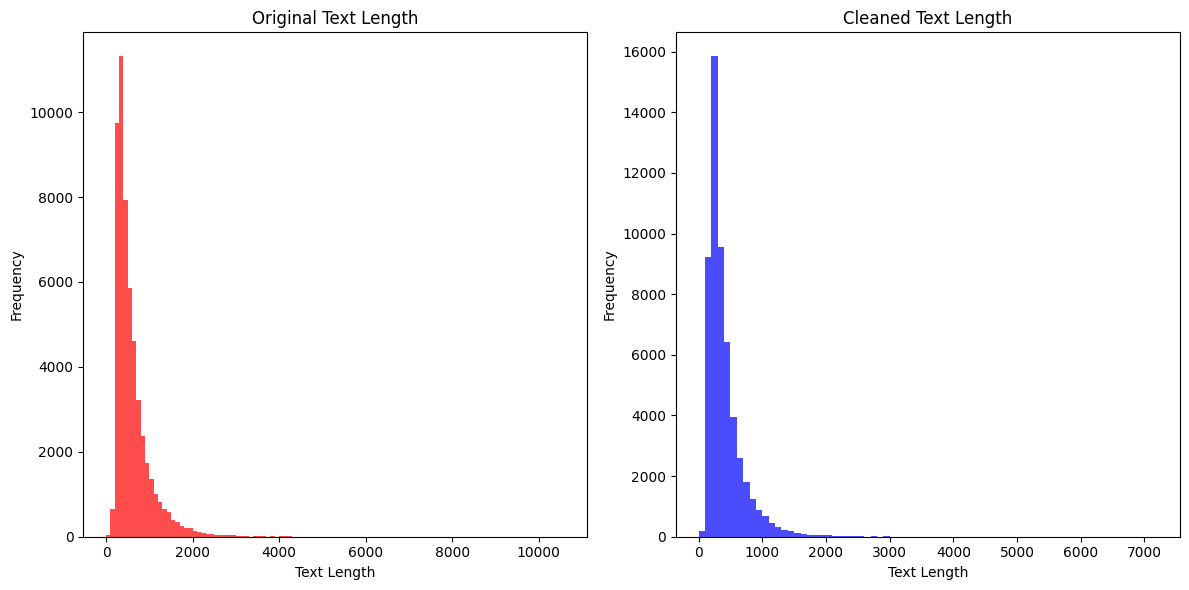

In [21]:
plt.figure(figsize = (12, 6))

plt.subplot(1, 2, 1)
original_length = train_data['DESCRIPTION'].apply(len)
plt.hist(original_length, bins = range(0, max(original_length) + 100, 100), color = 'red', alpha = 0.7)
plt.title('Original Text Length')
plt.xlabel('Text Length')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
cleaned_length = train_data['CLEAN_TEXT'].apply(len)
plt.hist(cleaned_length, bins = range(0, max(cleaned_length) + 100, 100), color = 'blue', alpha = 0.7)
plt.title('Cleaned Text Length')
plt.xlabel('Text Length')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

## Text Vecrorization

In [22]:
tfidf_vectorizer = TfidfVectorizer()
V_train = tfidf_vectorizer.fit_transform(train_data['CLEAN_TEXT'])
V_test = tfidf_vectorizer.transform(test_data['CLEAN_TEXT'])

In [23]:
X_train = V_train
y_train = train_data['GENRE']
X_test = V_test
y_test = test_data['GENRE']

In [24]:
modelNB = MultinomialNB().fit(X_train, y_train)
y_predNB = modelNB.predict(X_test)
accuracyNB = accuracy_score(y_test, y_predNB)
print("Accuracy:", accuracyNB)

Accuracy: 0.4435608856088561


In [25]:
modelLR= LogisticRegression(max_iter=1000).fit(X_train, y_train)
y_predLR = modelLR.predict(X_test)
accuracyLR = accuracy_score(y_test, y_predLR)
print("Accuracy:",accuracyLR)

Accuracy: 0.5892250922509225


In [26]:
# modelSVC = SVC(kernel='linear', C=1.0, gamma='scale').fit(X_train, y_train)
# y_predSVC = modelSVC.predict(X_test)
# accuracySVC = accuracy_score(y_test, y_predSVC)
# print("Accuracy:",accuracySVC)